# 互评作业3——分类、预测与聚类（选择进行预测任务）

## 1 数据集概述

选用的Hotel booking demand数据集，对酒店预订的需求进行分析与预测，该数据集共有119390条数据，32项属性标签

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 内嵌画图
%matplotlib inline

* 数据分析工具：Numpy，Pandas
* 读取数据，概览数据

In [2]:
df = pd.read_csv("./data/HotelBooking/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 2 对数据集的基本分析

### 2.1 基本情况：城市酒店和假日酒店预订需求和入住率比较

In [3]:
cols = df.columns
cols

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

统计数据缺失值

In [4]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
df_new = df.copy(deep = True)
df_new.drop("company", axis=1, inplace=True)
df_new["agent"].fillna(0, inplace=True)
df_new["children"].fillna(df_new["children"].mode()[0], inplace=True)
df_new["country"].fillna(df_new["country"].mode()[0], inplace=True)

In [6]:
lis = df_new.hotel.value_counts()
lis

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

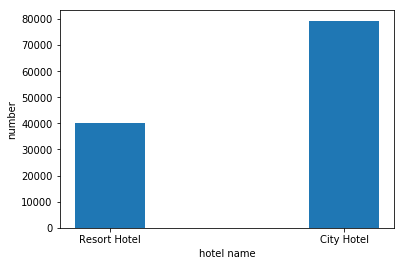

In [7]:
rh = lis['Resort Hotel']
ch = lis['City Hotel']
data0 = [rh,ch]
index0 = np.arange(2)

plt.bar(index0, data0, width=0.3)
# plt.hist(data0, bins=3)
plt.xlabel('hotel name')
plt.xticks(index0,('Resort Hotel','City Hotel'))
plt.ylabel('number')
plt.show()

从预订需求量上来看，城市酒店为79330，而假日酒店为40060，所以城市酒店的需求量较大，远高于假日酒店

In [8]:
rh_iscancel_count = df_new[df_new["hotel"]=="Resort Hotel"].groupby(["is_canceled"])["is_canceled"].count()
ch_iscancel_count = df_new[df_new["hotel"]=="City Hotel"].groupby(["is_canceled"])["is_canceled"].count()

In [9]:
rh_iscancel_count

is_canceled
0    28938
1    11122
Name: is_canceled, dtype: int64

In [10]:
ch_iscancel_count

is_canceled
0    46228
1    33102
Name: is_canceled, dtype: int64

In [11]:
rh_num = rh_iscancel_count[0]/lis['Resort Hotel']
rh_num

0.7223664503245132

In [12]:
ch_num = ch_iscancel_count[0]/lis['City Hotel']
ch_num

0.5827303668221354

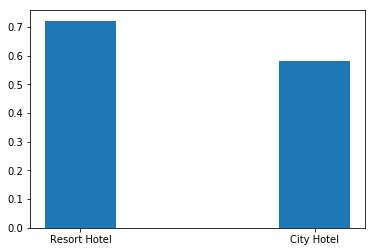

In [13]:
data = [rh_num,ch_num]
index = np.arange(2)
plt.bar(index, data, width=0.3)
plt.xticks(index,('Resort Hotel','City Hotel'))
plt.show()

从入住率上来看，城市酒店为58%，而假日酒店为72%，假日酒店的入住率远高于城市酒店。

### 2.2 用户行为：提前预订时间、预订间隔、入住时长、餐食预订情况

#### 2.2.1 提前预订时间

In [14]:
df_new['lead_time'].describe()

count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64

可以从上述数据看到，平均提前预定时间为104，最小值为0，最大值为737

#### 2.2.2 预订间隔

In [15]:
df_new['days_in_waiting_list'].describe()

count    119390.000000
mean          2.321149
std          17.594721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         391.000000
Name: days_in_waiting_list, dtype: float64

查看预订间隔的五数概括，可以知道：平均预定间隔为2，最小值为0，最大值为391，并且多数时间很短

#### 2.2.3 入住时长

通过统计“入住时长 =周末停留夜晚数+工作日停留夜晚数”可以获得

In [16]:
df_new["total_nights"] = df_new["stays_in_weekend_nights"] + df_new["stays_in_week_nights"]

In [17]:
df_new['total_nights'].describe()

count    119390.000000
mean          3.427900
std           2.557439
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          69.000000
Name: total_nights, dtype: float64

可以看到，平均入住时间为3天，最小值为0天，最大值为69天

#### 2.2.4 餐食预订情况

In [18]:
df_new['meal'].value_counts()

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

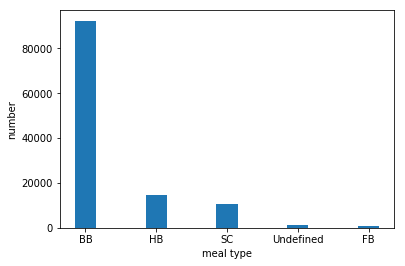

In [19]:
foodBook = df_new.meal.value_counts()
bb = foodBook['BB']
hb = foodBook['HB']
sc = foodBook['SC']
un = foodBook['Undefined']
fb= foodBook['FB']
data1 = [bb,hb,sc,un,fb]
index1 = np.arange(5)

plt.bar(index1, data1, width=0.3)
plt.xlabel('meal type')
plt.xticks(index1,('BB','HB','SC','Undefined','FB'))
plt.ylabel('number')
plt.show()

从图中可以得知，多数房间都预订BB类型餐食，同时也有不订餐的选择

## 2.3 一年中预订酒店最佳的时间

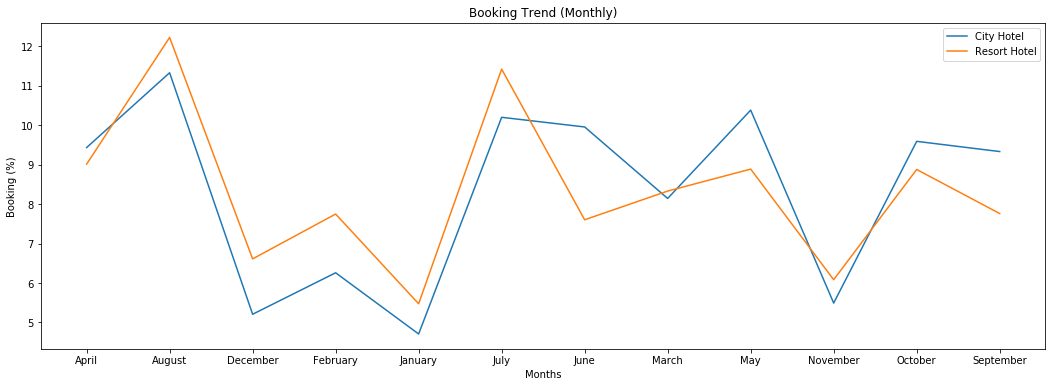

In [20]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


sorted_months = df_new.loc[df.hotel=='City Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x1 = sorted_months.index
y1 = sorted_months/sorted_months.sum()*100


sorted_months = df_new.loc[df.hotel=='Resort Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x2 = sorted_months.index
y2 = sorted_months/sorted_months.sum()*100


fig, ax = plt.subplots(figsize=(18,6))

ax.set_xlabel('Months')
ax.set_ylabel('Booking (%)')
ax.set_title('Booking Trend (Monthly)')


sns.lineplot(x1, y1.values, label='City Hotel')
sns.lineplot(x1, y2.values, label='Resort Hotel')

plt.show()

从图中酒店的入住情况可以看到，一年中最佳预订酒店时间为：12月和2月，这两月酒店的入住量最低，属于预订的淡季，价格会较为合理，最适合预订酒店。

## 3 利用Logistic模型预测酒店预订

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           119390 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

将Dataframe中的分类数据转化为数值数据

In [22]:
df_new = pd.get_dummies(df_new)
df_new

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reservation_status_date_2017-09-03,reservation_status_date_2017-09-04,reservation_status_date_2017-09-05,reservation_status_date_2017-09-06,reservation_status_date_2017-09-07,reservation_status_date_2017-09-08,reservation_status_date_2017-09-09,reservation_status_date_2017-09-10,reservation_status_date_2017-09-12,reservation_status_date_2017-09-14
0,0,342,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,737,2015,27,1,0,0,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,9,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,85,2015,27,1,0,3,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,75,2015,27,1,0,3,2,0.0,0,...,0,0,0,0,0,0,0,0,0,0


按照7:3的比例划分训练集和测试集

In [23]:
def data_split(df, label):
    
    from sklearn.model_selection import train_test_split

    X = df.drop(label, axis=1)
    Y = df[label]

    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
    
    return x_train, x_test, y_train, y_test



x_train, x_test, y_train, y_test = data_split(df_new, 'is_canceled')

开始训练模型

In [24]:
def train(x_train, y_train):
    from sklearn.linear_model import LogisticRegression

    clf = LogisticRegression(random_state = 0, max_iter=100)
    clf.fit(x_train,y_train)
    
    return clf


clf = train(x_train, y_train)

In [25]:
def Score(clf,x_train,y_train,x_test,y_test):
    train_score = clf.score(x_train,y_train)
    test_score = clf.score(x_test,y_test)

    print("==========================================================")
    print('Training Accuracy of our model is: %f'% train_score)
    print('Test Accuracy of our model is: %f'% test_score)
    print("==========================================================")
    
    
Score(clf,x_train,y_train,x_test,y_test)

Training Accuracy of our model is: 0.999976
Test Accuracy of our model is: 0.999944


可以看到，利用logistics模型进行预测，最终模型准确率为99%左右。